# Minibackend example
This notebook aims to illustrate how `openeo-pg-parser-networkx` can be used together with `openeo-processes-dask` to execute an OpenEO process graph locally.
Note: This capability has also been called the "mini-backend" (see [GH issue with discussion](https://github.com/Open-EO/PSC/issues/16)).

We'll demonstrate this capability through the following steps:
- Load a process graph that represents a computation to be executed on an OpenEO backend and parse it to a traversible Python object using `openeo-pg-parser-networkx`
- Traverse the process graph and maps the nodes to a nested Python function
- Execute that function

Let's go!

## Process graph creation
We'll keep it super simple and use a process graph that: 
1) loads a small part of the boa_sentinel_2 collection
2) computes normalized difference vegetation index (NDVI) for each pixel
3) multiplies each pixel with a scalar 
4) saves the result as a NetCDF

Specifically, the OpenEO processes necessary to encode this computation are:
1) `load_collection`
2) `apply`
    - subprocess: `ndvi`
3) `apply`
    - subprocess: `multiply`
4) `save_result`

In [1]:
from openeo_pg_parser_networkx import OpenEOProcessGraph

NDVI_GRAPH_PATH = "../tests/data/graphs/apply.json"

parsed_graph = OpenEOProcessGraph.from_file(NDVI_GRAPH_PATH)

Deserialised process graph into nested structure


Walking node root-127f72cc-4f0a-4518-9ebe-864da92944e5
Walking node apply2-127f72cc-4f0a-4518-9ebe-864da92944e5
Walking node multiply1-551f99af-b411-4757-8e73-db2031b41404
Walking node apply1-127f72cc-4f0a-4518-9ebe-864da92944e5
Walking node ndvi1-445b0b95-793d-46ff-b20b-9dac222825b8
Walking node loadcollection1-127f72cc-4f0a-4518-9ebe-864da92944e5


In [2]:
parsed_graph

We can see that `OpenEOProcessGraph` has parsed the process graph - let's plot it!


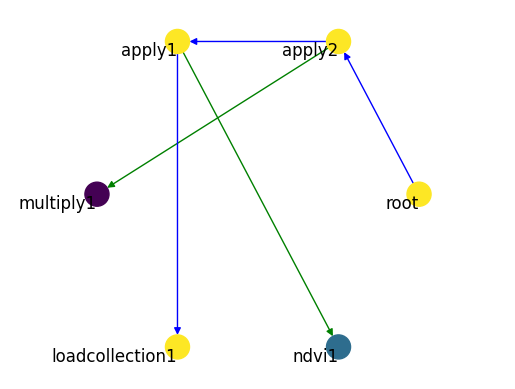

In [15]:
parsed_graph.plot()

The blue edges signify a `ResultReference` edge, where the result of the upstream process needs to be passed down to the downstream process as a parameter. 
E.g. in this process graph the results of `load_collection1` need to be passed on to `apply1`. 
The red edges indicate `Callback` edges. These occur when a "parent" process calls upon a "child" process, i.e. to apply a reducer over specific dimension of a datacube. 
In this case the parent process is `apply`, which applies the `ndvi` process over all the pixels.  

## Execute the process graph

To execute a process graph, `OpenEOProcessGraph` needs to know which Python code to call for each of the nodes in the graph. This information is provided by a "process registry", which is basically a dictionary that maps `process_id` to their actual Python implementations as `Callable`s.

 When provided with a ProcessRegistry object (as defined in [openeo-processes-dask](https://github.com/Open-EO/openeo-processes-dask/blob/main/openeo_processes_dask/core.py)), `OpenEOProcessGraph` can translate the process graph into Python code using the `to_callable()` method.

In [ ]:
!pip install openeo_processes_dask

In [17]:
from openeo_pg_parser_networkx import ProcessRegistry
process_registry = ProcessRegistry()

# Import these pre-defined processes from openeo_processes_dask and register into registry
from openeo_processes_dask.process_implementations import apply, ndvi, multiply

process_registry["apply"] = apply
process_registry["ndvi"] = ndvi
process_registry["multiply"] = multiply

# I/O processes aren't generic (yet), therefore have to custom define those. 
def load_collection(id, spatial_extent, temporal_extent, bands = [], properties = {}, **kwargs):
    # No generic implementation available, so need to implement locally!
    pass

def save_result(data, format = 'netcdf', options = None):
    # No generic implementation available, so need to implement locally!
    pass

process_registry["load_collection"] = load_collection
process_registry["save_result"] = save_result

In [18]:
pg_callable = parsed_graph.to_callable(process_registry=process_registry)

In [ ]:
pg_callable()